<a href="https://colab.research.google.com/github/KAFE45/Colab-LabBCI/blob/main/KAFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mne pyxdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 41.3 MB/s eta 0:00:00


In [2]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from google.colab import files
import io
from scipy.fft import fft

In [3]:
# Upload file
uploaded = files.upload()

# Select uploaded file
file_name = list(uploaded.keys())[0]

Saving sub-DataSSVEP551_ses-S002_task-Default_run-001_eeg.xdf to sub-DataSSVEP551_ses-S002_task-Default_run-001_eeg.xdf


In [26]:
# ฟังก์ชันสำหรับโหลดข้อมูลจากไฟล์ .xdf
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

In [ ]:
# ฟังก์ชันสำหรับตัดสัญญาณ EEG รอบๆ มาร์กเกอร์ที่เลือก
def cut_signal_for_selected_markers(df, sampling_rate, markers, selected_markers, pre_marker_sec=1, post_marker_sec=2):
    cut_segments = []
    for timestamp, marker in markers:
        marker_value = marker[0]

        # ตรวจสอบว่าค่ามาร์กเกอร์อยู่ในรายการมาร์กเกอร์ที่ต้องการหรือไม่
        if marker_value in selected_markers:
            # คำนวณตำแหน่งเริ่มต้นและสิ้นสุดสำหรับช่วงสัญญาณ
            start_idx = int((timestamp - pre_marker_sec) * sampling_rate)
            end_idx = int((timestamp + post_marker_sec) * sampling_rate)

            # ตรวจสอบว่าตำแหน่งอยู่ภายในขอบเขตข้อมูล
            if start_idx >= 0 and end_idx <= len(df):
                segment = df.iloc[start_idx:end_idx]  # ตัดสัญญาณช่วงที่สนใจ
                cut_segments.append((segment, marker_value))

    return cut_segments

# โหลดข้อมูลจากไฟล์ .xdf
eeg_data, sampling_rate, markers_data = load_data('/content/sub-DataSSVEP551_ses-S002_task-Default_run-001_eeg.xdf')

# แสดงมาร์กเกอร์ทั้งหมดที่พบในไฟล์
print("Markers from File:")
for timestamp, marker in markers_data:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# กำหนดมาร์กเกอร์ที่สนใจ
selected_markers = [1, 2, 4]

# ตัดสัญญาณ EEG รอบๆ มาร์กเกอร์ที่เลือก
cut_segments = cut_signal_for_selected_markers(eeg_data, sampling_rate, markers_data, selected_markers)

# แสดงผลช่วงที่ตัด
for segment, marker in cut_segments:
    print(f"Marker {marker} - Signal Segment: \n{segment}\n")
    print("-" * 40)  # เส้นแบ่งระหว่างช่วงสัญญาณ


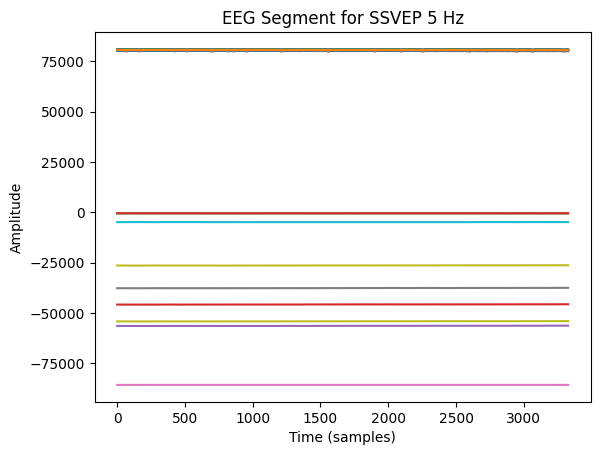

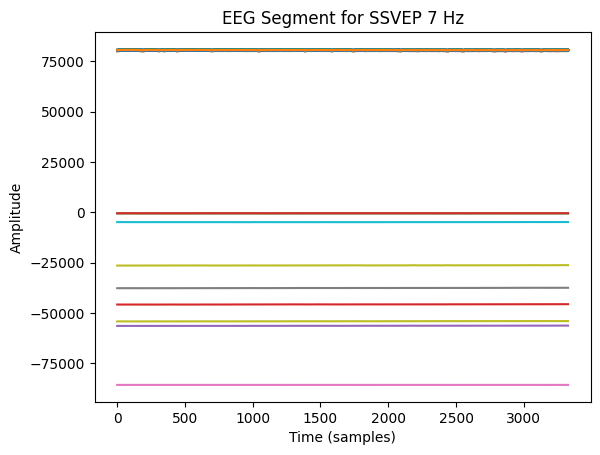

In [50]:
# สมมุติให้ eeg_stream และ marker_stream ชื่อของสตรีมที่ใช้
eeg_stream = [s for s in streams if s['info']['name'][0] == 'eeg'][0]
marker_stream = [s for s in streams if s['info']['name'][0] == 'PsychoPyMarkers'][0]

# รับข้อมูลสัญญาณ EEG และมาร์กเกอร์
eeg_data = eeg_stream['time_series']
markers = marker_stream['time_series']

# กำหนดมาร์กเกอร์ที่ใช้สำหรับ SSVEP
ssvep_5hz_trigger_start = 2  # Start trigger for SSVEP 5 Hz
ssvep_5hz_trigger_end = 12    # End trigger for SSVEP 5 Hz
ssvep_7hz_trigger_start = 4   # Start trigger for SSVEP 7 Hz
ssvep_7hz_trigger_end = 14     # End trigger for SSVEP 7 Hz

# ฟังก์ชันในการตัดสัญญาณตามมาร์กเกอร์
def cut_ssvep_segments(eeg_data, markers, start_triggers, end_triggers, pre_time=1, post_time=2, fs=256):
    segments = []
    for marker in markers:
        # ตรวจสอบการจับคู่กับมาร์กเกอร์ที่เริ่มต้นและสิ้นสุด
        if marker[0] in start_triggers:
            start_idx = int((marker[0] - pre_time) * fs)  # คำนวณเวลาเริ่มต้น
            end_idx = int((end_triggers[start_triggers.index(marker[0])] + post_time) * fs)  # คำนวณเวลาสิ้นสุด
            segment = eeg_data[start_idx:end_idx]  # ตัดสัญญาณ
            segments.append(segment)
    return segments

# กำหนดลิสต์สำหรับการจับคู่มาร์กเกอร์เริ่มต้นและสิ้นสุด
start_triggers = [ssvep_5hz_trigger_start, ssvep_7hz_trigger_start]
end_triggers = [ssvep_5hz_trigger_end, ssvep_7hz_trigger_end]

# ตัดสัญญาณ EEG ตามมาร์กเกอร์
eeg_segments = cut_ssvep_segments(eeg_data, markers, start_triggers, end_triggers)

# แสดงผล
for i, segment in enumerate(eeg_segments):
    plt.figure()
    plt.plot(segment)
    plt.title(f'EEG Segment for SSVEP {5 + 2*i} Hz')  # เปลี่ยนชื่อเป็น 5 Hz และ 7 Hz
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
# ฟังก์ชันสำหรับตัดสัญญาณ EEG รอบๆ มาร์กเกอร์ที่เลือก
def cut_signal_for_selected_markers(df, sampling_rate, markers, selected_markers, pre_marker_sec=1, post_marker_sec=2):
    cut_segments = []
    for timestamp, marker in markers:
        marker_value = marker[0]

        # ตรวจสอบว่าค่ามาร์กเกอร์อยู่ในรายการมาร์กเกอร์ที่ต้องการหรือไม่
        if marker_value in selected_markers:
            # คำนวณตำแหน่งเริ่มต้นและสิ้นสุดสำหรับช่วงสัญญาณ
            start_idx = int((timestamp - pre_marker_sec) * sampling_rate)
            end_idx = int((timestamp + post_marker_sec) * sampling_rate)

            # ตรวจสอบว่าตำแหน่งอยู่ภายในขอบเขตข้อมูล
            if start_idx >= 0 and end_idx <= len(df):
                segment = df.iloc[start_idx:end_idx]  # ตัดสัญญาณช่วงที่สนใจ
                cut_segments.append((segment, marker_value))

    return cut_segments

In [29]:
# Show markers
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

Markers from File 1:
Timestamp: 13241.40, Marker: 13
Timestamp: 13241.40, Marker: 2
Timestamp: 13271.39, Marker: 12
Timestamp: 13271.39, Marker: 3
Timestamp: 13301.40, Marker: 13
Timestamp: 13301.40, Marker: 4
Timestamp: 13331.40, Marker: 14
Timestamp: 13331.40, Marker: 3
Timestamp: 13361.40, Marker: 13
Timestamp: 13361.40, Marker: 1


In [51]:
# Function for cutting EEG signal around specific markers
def cut_signal_for_selected_markers(df, sampling_rate, markers, selected_markers, pre_marker_sec=1, post_marker_sec=2):
    cut_segments = []
    for timestamp, marker in markers:
        marker_value = marker[0]

        # Check if the marker is in the selected markers list
        if marker_value in selected_markers:
            start_idx = int((timestamp - pre_marker_sec) * sampling_rate)
            end_idx = int((timestamp + post_marker_sec) * sampling_rate)

            # Check that the indices are within bounds
            if start_idx >= 0 and end_idx <= len(df):
                segment = df.iloc[start_idx:end_idx]
                cut_segments.append((segment, marker_value))

    return cut_segments

In [39]:
# Define selected markers (2, 12, 4, 14)
selected_markers = [2, 12, 4, 14]
print(selected_markers)

[2, 12, 4, 14]


In [40]:
# Load data
df1, sampling_rate1, markers1 = load_data(io.BytesIO(uploaded[file_name]))
print(df1, sampling_rate1, markers1)

          Channel 1     Channel 2     Channel 3     Channel 4            O1  \
0      80789.429688  80448.257812  80705.367188  80376.078125 -56394.390625   
1      80757.500000  80416.539062  80677.367188  80344.351562 -56395.125000   
2      80745.625000  80399.476562  80660.359375  80328.953125 -56397.460938   
3      80771.046875  80423.484375  80681.015625  80352.062500 -56399.183594   
4      80790.734375  80445.218750  80702.406250  80373.773438 -56400.160156   
...             ...           ...           ...           ...           ...   
38771  80630.578125  80281.156250  80537.890625  80213.281250 -54287.699219   
38772  80638.265625  80295.148438  80555.156250  80226.179688 -54286.429688   
38773  80591.523438  80253.859375  80519.531250  80184.953125 -54285.082031   
38774  80561.726562  80220.945312  80483.226562  80152.476562 -54281.312500   
38775  80572.367188  80227.914062  80483.156250  80158.921875 -54278.046875   

          Channel 6     Channel 7     Channel 8    

In [41]:
# Cut segments for the selected markers
cut_segments_selected = cut_signal_for_selected_markers(df1, sampling_rate1, markers1, selected_markers)

print(f"จำนวน segment ที่ถูกตัด: {len(cut_segments_selected)}")

จำนวน segment ที่ถูกตัด: 0


In [42]:
# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [43]:
# Plot power spectrum
def plot_power_spectrum(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.grid()
            plt.xlim(0, 10)
            plt.xticks(np.arange(1, 11, 1))

            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()
    plt.show()

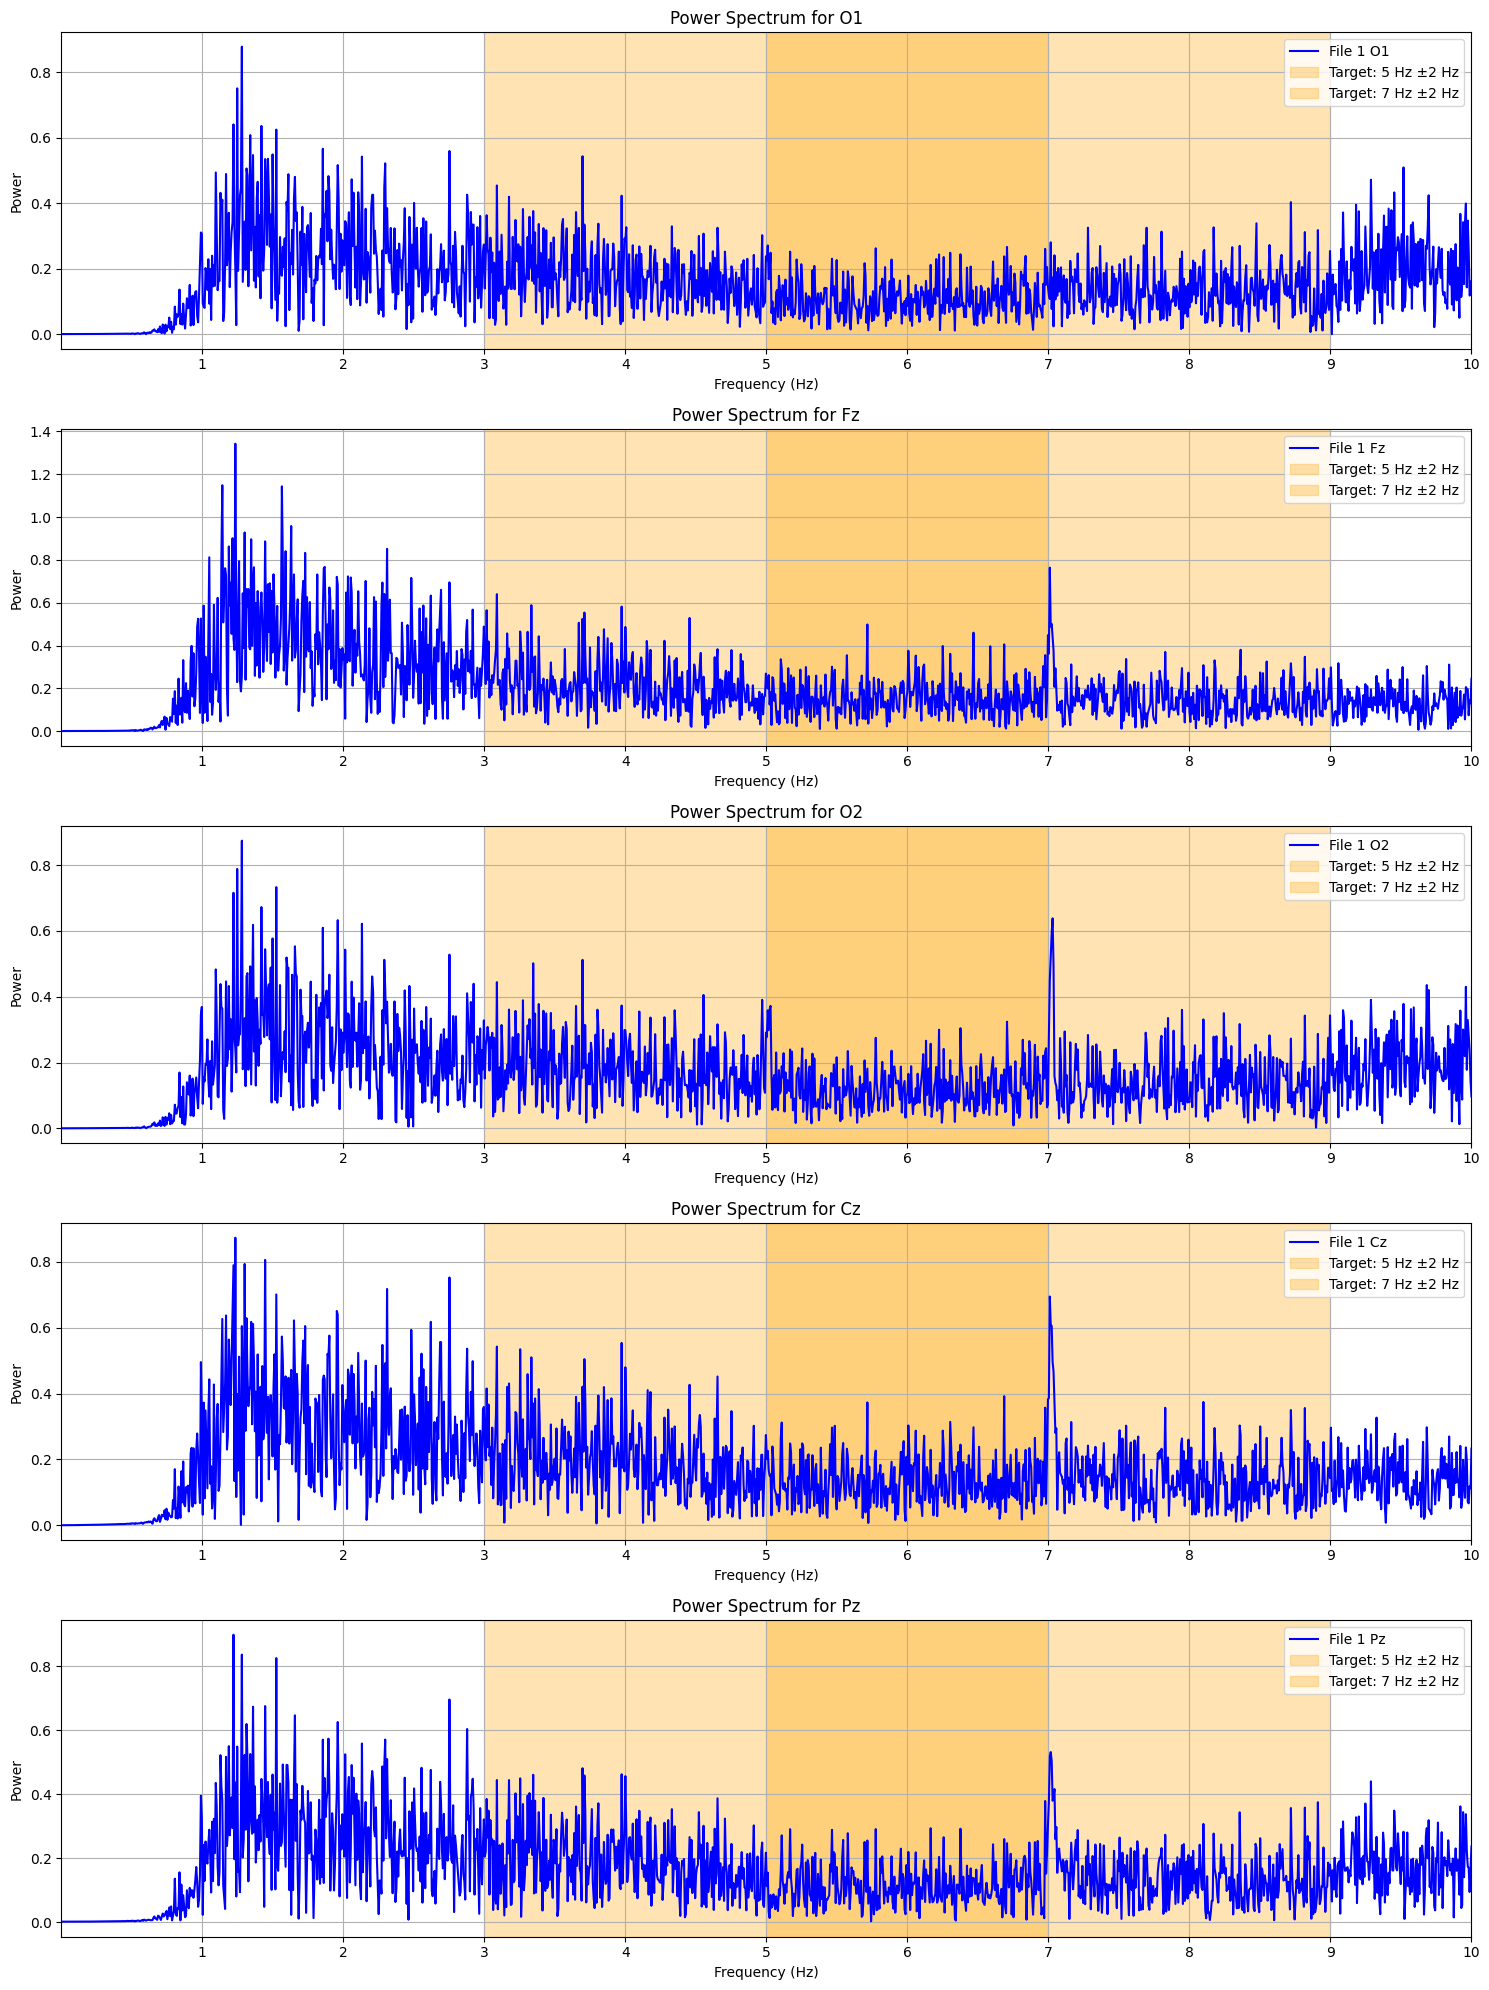

In [44]:
# Plot power spectrum for each selected segment
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']
plot_power_spectrum(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freqs=[5, 7], bandwidth=2)